In [10]:
# Imports
import gc
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.linear_model import LassoCV

## Testing parallel trends assumption

In [15]:
# Set seaborn style
sns.set_theme()  # (style="whitegrid")
warnings.filterwarnings("ignore")


# 1. Data Preparation Function
def prepare_forum_data(forum_df, forum_name, so=False):
    """
    Prepare and standardize data from a Stack Exchange forum.

    Parameters:
    -----------
    forum_df : polars.DataFrame
        DataFrame containing Posts.xml data for a forum
    forum_name : str
        Name of the forum

    Returns:
    --------
    polars.DataFrame
        Standardized dataframe with question counts
    """

    needs_conversion = forum_df["CreationDate"].dtype != pl.Datetime

    # SO needs slitghtly different handling
    if so:
        questions_df = (
            forum_df
            # Conditionally convert CreationDate to datetime in the pipeline
            .with_columns(
                pl.col("CreationDate")
                .str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S.%f")
                .alias("CreationDate")
                if needs_conversion
                else pl.col("CreationDate"),
                pl.when(pl.col("tag_list").list.contains("python"))
                .then(pl.lit("Python"))
                .when(pl.col("tag_list").list.contains("r"))
                .then(pl.lit("R"))
                .when(pl.col("tag_list").list.contains("php"))
                .then(pl.lit("PHP"))
                .otherwise(pl.lit("JavaScript"))
                .alias("group"),
            )
            .with_columns(
                pl.col("CreationDate").dt.date().alias("date"),
                pl.col("CreationDate").dt.year().alias("year"),
                pl.col("CreationDate").dt.month().alias("month"),
                pl.col("CreationDate").dt.weekday().alias("day_of_week"),
                # ISO week of year
                pl.col("CreationDate").dt.week().alias("week"),
            )
            # Create year-week identifier
            .with_columns((pl.col("year") * 100 + pl.col("week")).alias("yearweek"))
            # Add forum identifier
            .with_columns(pl.lit(forum_name).alias("forum"))
            # Aggregate to weekly level
            .group_by(["yearweek", "year", "week", "forum", "group"])
            .agg(
                pl.len().alias("question_count"),
                pl.col("date").min().alias("week_start"),
                # Optional: additional metrics if you have them
                pl.col("Score").mean().alias("avg_score"),
                pl.col("ViewCount").mean().alias("avg_views"),
                pl.col("CommentCount").mean().alias("avg_comments"),
            )
        )
        return questions_df

    questions_df = (
        forum_df
        # Conditionally convert CreationDate to datetime in the pipeline
        .with_columns(
            pl.col("CreationDate")
            .str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S.%f")
            .alias("CreationDate")
            if needs_conversion
            else pl.col("CreationDate"),
            # Add forum identifier
            pl.lit(forum_name).alias("forum"),
            # And group for stata and SO compatibility
            pl.lit(forum_name).alias("group"),
        )
        .with_columns(
            pl.col("CreationDate").dt.date().alias("date"),
            pl.col("CreationDate").dt.year().alias("year"),
            pl.col("CreationDate").dt.month().alias("month"),
            pl.col("CreationDate").dt.weekday().alias("day_of_week"),
            # ISO week of year
            pl.col("CreationDate").dt.week().alias("week"),
        )
        # Create year-week identifier
        .with_columns((pl.col("year") * 100 + pl.col("week")).alias("yearweek"))
        # Aggregate to weekly level
        .group_by(["yearweek", "year", "week", "forum", "group"])
        .agg(
            pl.len().alias("question_count"),
            pl.col("date").min().alias("week_start"),
            # Optional: additional metrics if you have them
            pl.col("Score").mean().alias("avg_score"),
            pl.col("ViewCount").mean().alias("avg_views"),
            pl.col("CommentCount").mean().alias("avg_comments"),
        )
    )
    return questions_df


# 2. Load and prepare all forum data
# Load data
df_so = pl.read_parquet(
    "../data/batched_processing/stackoverflow_processed_batch.parquet"
)
# df_so = pl.read_parquet("../data/stackoverflow/stackoverflow_script.parquet")
# df_so = pl.read_parquet(
#    "../data/stackoverflow/stackoverflow.parquet"
# )  # Use this to get the overall effect of ChatGPT not only on scripting languages
stackoverflow_weekly = prepare_forum_data(df_so, "Stack Overflow", so=True)
# Clean memory
del df_so
gc.collect()
df_math = pl.read_parquet("../data/math/math.parquet")
df_physics = pl.read_parquet("../data/physics/physics.parquet")
df_superuser = pl.read_parquet("../data/superuser/superuser.parquet")
df_askubuntu = pl.read_parquet("../data/askubuntu/askubuntu.parquet")
math_weekly = prepare_forum_data(df_math, "Mathematics")
del df_math
physics_weekly = prepare_forum_data(df_physics, "Physics")
del df_physics
superuser_weekly = prepare_forum_data(df_superuser, "Superuser")
del df_superuser
askubuntu_weekly = prepare_forum_data(df_askubuntu, "Askubuntu")
del df_askubuntu
gc.collect()

0

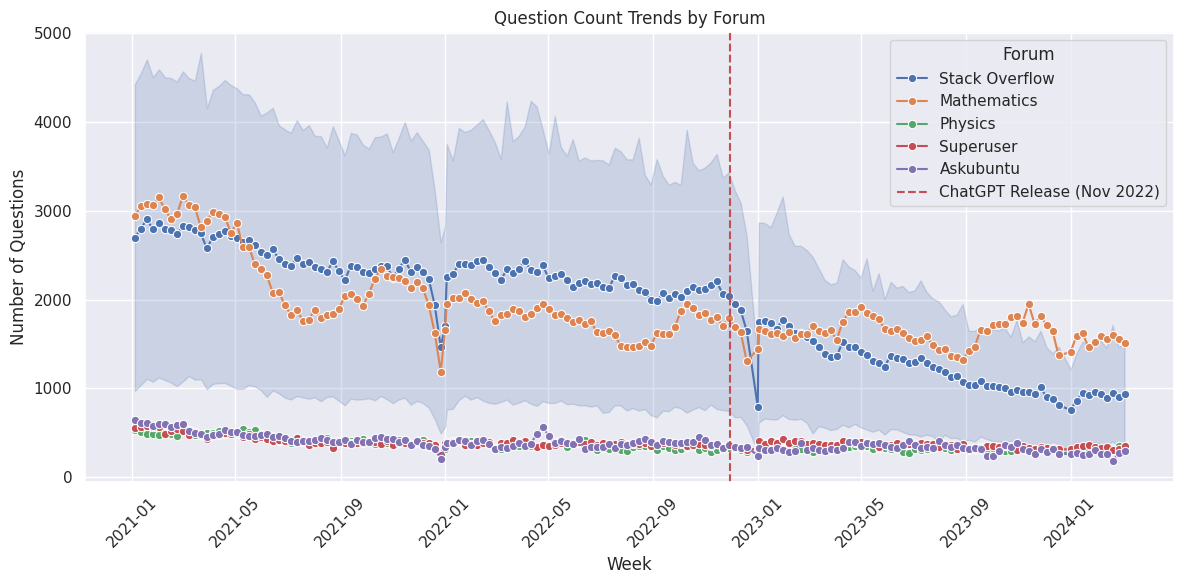

In [16]:
# 3. Combine all forum data
all_forums_weekly = pl.concat(
    [
        stackoverflow_weekly,
        math_weekly,
        physics_weekly,
        superuser_weekly,
        askubuntu_weekly,
    ],
    how="diagonal_relaxed",
)

# 4. Visualize the data to check for parallel trends
plt.figure(figsize=(12, 6))
treatment_date = datetime(2022, 11, 30)


# Drop first week and last two as they are non-representative
all_forums_weekly = all_forums_weekly.filter(
    pl.col("week_start") > datetime(2021, 1, 1),
    pl.col("week_start") <= datetime(2024, 3, 4),
)
# Convert to pandas for plotting with seaborn
all_forums_weekly_pd = all_forums_weekly.to_pandas()

# Plot trends
sns.lineplot(
    data=all_forums_weekly,
    x="week_start",
    y="question_count",
    hue="forum",
    marker="o",
)

# Add vertical line for treatment date
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Question Count Trends by Forum")
plt.xlabel("Week")
plt.ylabel("Number of Questions")
plt.legend(title="Forum")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Enhanced DiD

In [17]:
# 5. Normalize data to address scale differences
def prepare_forum_data_normalized(forum_df, forum_name):
    """
    Prepare and standardize data from a Stack Exchange forum with normalization.
    """
    # Filter to questions only (PostTypeId = 1)
    questions_df = forum_df.filter(pl.col("PostTypeId") == "1")

    # Convert CreationDate to datetime if it's not already
    if questions_df["CreationDate"].dtype != pl.Datetime:
        questions_df = questions_df.with_columns(
            pl.col("CreationDate").str.strptime(
                pl.Datetime, format="%Y-%m-%dT%H:%M:%S.%f"
            )
        )

    # Extract basic date components
    questions_df = questions_df.with_columns(
        [
            pl.col("CreationDate").dt.date().alias("date"),
            pl.col("CreationDate").dt.year().alias("year"),
            pl.col("CreationDate").dt.month().alias("month"),
            pl.col("CreationDate").dt.weekday().alias("day_of_week"),
            pl.col("CreationDate").dt.week().alias("week"),
        ]
    )

    # Create year-week identifier
    questions_df = questions_df.with_columns(
        (pl.col("year") * 100 + pl.col("week")).alias("yearweek")
    )

    # Add forum identifier
    questions_df = questions_df.with_columns(pl.lit(forum_name).alias("forum"))

    # Aggregate to weekly level
    weekly_df = questions_df.group_by(["yearweek", "year", "week", "forum"]).agg(
        [
            pl.count().alias("question_count"),
            pl.col("date").min().alias("week_start"),
            pl.col("Score").mean().alias("avg_score"),
            pl.col("ViewCount").mean().alias("avg_views"),
            pl.col("CommentCount").mean().alias("avg_comments"),
        ]
    )

    return weekly_df


# 6. Addressing non-parallel trends: Log transformation for question counts
def transform_for_parallel(all_forums_weekly):
    """Apply transformations to help achieve more parallel trends"""
    # First, apply log transformation for question count
    transformed_df = all_forums_weekly.with_columns(
        pl.col("question_count")
        .map_elements(lambda x: np.log1p(x))
        .alias("log_question_count")
    )

    # Get all unique forums
    forums = transformed_df["forum"].unique().to_list()

    # Create indexed count expressions for each forum
    indexed_exprs = []
    for forum in forums:
        # Get the first period value for this forum
        first_value = (
            transformed_df.filter(pl.col("forum") == forum)
            .sort("week_start")
            .select(pl.col("question_count"))
            .head(1)
            .item()
        )

        # Add conditional expression for this forum
        indexed_exprs.append(
            pl.when(pl.col("forum") == forum)
            .then(100 * pl.col("question_count") / first_value)
            .otherwise(0)  # Will be overwritten by other forum conditions
        )

    # Combine all expressions with sum() to create the indexed_count column
    if indexed_exprs:
        final_expr = indexed_exprs[0]
        for expr in indexed_exprs[1:]:
            final_expr = final_expr + expr

        # Add the indexed column
        transformed_df = transformed_df.with_columns(final_expr.alias("indexed_count"))

    return transformed_df


# 7. Visualize different transformations to check for better parallel trends
def visualize_transformations(transformed_data):
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    treatment_date = datetime(2022, 11, 30)

    # Convert to pandas for easier plotting with seaborn
    transformed_data_pd = transformed_data.to_pandas()

    # Plot 1: Raw question counts
    sns.lineplot(
        data=transformed_data_pd,
        x="week_start",
        y="question_count",
        hue="forum",
        marker="o",
        ax=axes[0],
    )
    axes[0].axvline(
        x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
    )
    axes[0].set_title("Raw Question Counts")
    axes[0].set_ylabel("Number of Questions")
    axes[0].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), ncol=1)
    # Place legend below the plot
    # axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=6)

    # Plot 2: Log-transformed question counts
    sns.lineplot(
        data=transformed_data_pd,
        x="week_start",
        y="log_question_count",
        hue="forum",
        marker="o",
        ax=axes[1],
    )
    axes[1].axvline(
        x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
    )
    axes[1].set_title("Log-Transformed Question Counts")
    axes[1].set_ylabel("Log(Number of Questions + 1)")
    axes[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), ncol=1)
    # Place legend below the plot
    # axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=6)

    # # Plot 3: Indexed question counts (first period = 100)
    # sns.lineplot(
    #     data=transformed_data_pd,
    #     x="week_start",
    #     y="indexed_count",
    #     hue="forum",
    #     marker="o",
    #     ax=axes[2],
    # )
    # axes[2].axvline(
    #     x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
    # )
    # axes[2].set_title("Indexed Question Counts (First Period = 100)")
    # axes[2].set_ylabel("Index (First Period = 100)")
    # # Place legend below the plot
    # axes[2].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=6)

    plt.tight_layout()
    # plt.subplots_adjust(hspace=0.45)
    plt.savefig("../imgs/transformed_trends.svg")
    plt.show()

    return fig


# 8. Test for parallel trends with different transformations
def test_parallel_trends_transformed(transformed_data):
    """Test parallel trends assumption with different transformations"""
    # Convert to pandas for statsmodels
    transformed_data_pd = transformed_data.to_pandas()
    treatment_date = datetime(2022, 11, 30)

    # Filter to pre-treatment period
    pre_treatment = transformed_data_pd[
        transformed_data_pd["week_start"] <= treatment_date
    ].copy()

    # Create time trend variable
    pre_treatment["time_trend"] = pre_treatment.groupby("forum")["week_start"].rank()

    # Recode the forum variable to make Stack Overflow the reference
    pre_treatment["forum"] = pd.Categorical(
        pre_treatment["forum"],
        categories=[
            "Physics",
            "Stack Overflow",
            "Mathematics",
            "Superuser",
            "Askubuntu",
        ],
    )

    results = {}

    # Test raw counts
    formula_raw = "question_count ~ time_trend + forum + time_trend:forum"
    model_raw = smf.ols(formula_raw, data=pre_treatment).fit()
    results["Raw Counts"] = model_raw

    # Test log counts
    formula_log = "log_question_count ~ time_trend + forum + time_trend:forum"
    model_log = smf.ols(formula_log, data=pre_treatment).fit()
    results["Log Counts"] = model_log

    # Test indexed counts
    formula_idx = "indexed_count ~ time_trend + forum + time_trend:forum"
    model_idx = smf.ols(formula_idx, data=pre_treatment).fit()
    results["Indexed Counts"] = model_idx

    # Print summary of results
    print("Parallel Trends Tests for Different Transformations:")
    for name, model in results.items():
        print(f"\n{name}:")
        interactions = [var for var in model.params.index if "time_trend:forum" in var]
        p_values = model.pvalues[interactions]

        for var, p_val in zip(interactions, p_values):
            significance = (
                "Significant (non-parallel)"
                if p_val < 0.05
                else "Non-significant (parallel)"
            )
            print(f"{var}: p = {p_val:.4f} - {significance}")

    return results


# 9. Enhanced Synthetic Control Implementation
def enhanced_synthetic_control(
    outcome_var,
    control_vars,
    data,
    treatment_period,
    pre_treatment_mask,
    post_treatment_mask,
    outcome_transform=None,
):
    """
    Implements an enhanced synthetic control with several improvements:
    - Option for transformed outcome variable
    - Regularization strength selection
    - More robust placebo tests
    - Visualization of weights
    """
    # Apply transformation if specified
    if outcome_transform == "log":
        y_var = f"log_{outcome_var}"
    elif outcome_transform == "index":
        y_var = f"indexed_{outcome_var}"
    else:
        y_var = outcome_var

    # Extract pre-treatment data for fitting
    X_pre = data.loc[pre_treatment_mask, control_vars].values
    y_pre = data.loc[pre_treatment_mask, y_var].values

    # Test different regularization strengths
    alphas = np.logspace(-3, 1, 20)
    model = LassoCV(cv=5, alphas=alphas, positive=True, fit_intercept=True)
    model.fit(X_pre, y_pre)

    # Get weights
    weights = pd.Series(model.coef_, index=control_vars)

    # Predict counterfactual for all periods
    X_all = data.loc[:, control_vars].values
    y_counterfactual = model.predict(X_all)

    # Calculate treatment effects
    y_actual = data[y_var].values
    treatment_effects = y_actual - y_counterfactual

    # Calculate average treatment effect on the treated (ATT)
    att = np.mean(treatment_effects[post_treatment_mask])

    # Pre-treatment fit (R²)
    r2_pre = 1 - np.sum((y_pre - model.predict(X_pre)) ** 2) / np.sum(
        (y_pre - np.mean(y_pre)) ** 2
    )

    # Calculate MSPE (Mean Squared Prediction Error) for pre-treatment
    mspe_pre = np.mean((y_pre - model.predict(X_pre)) ** 2)

    # If using log transformation, calculate effects in original scale
    if outcome_transform == "log":
        # Convert predictions back to original scale
        y_actual_orig = np.exp(y_actual) - 1
        y_counterfactual_orig = np.exp(y_counterfactual) - 1
        treatment_effects_orig = y_actual_orig - y_counterfactual_orig
        att_orig = np.mean(treatment_effects_orig[post_treatment_mask])
    else:
        treatment_effects_orig = treatment_effects
        att_orig = att

    # More robust inference using placebo tests
    placebo_effects = []
    placebo_window = min(
        int(len(pre_treatment_mask) * 0.2), 10
    )  # Use last 20% or 10 periods

    if placebo_window > 5:  # Only if we have enough data
        for i in range(placebo_window):
            # Create a placebo treatment period
            placebo_mask = np.zeros(len(pre_treatment_mask), dtype=bool)
            placebo_mask[-placebo_window + i : -placebo_window + i + 1] = True

            # Only use earlier periods for training
            placebo_train = pre_treatment_mask & ~placebo_mask

            # Skip if not enough training data or empty test data
            if np.sum(placebo_train) < 10 or np.sum(placebo_mask) == 0:
                continue

            # Fit on earlier data
            X_placebo_train = data.loc[placebo_train, control_vars].values
            y_placebo_train = data.loc[placebo_train, y_var].values

            model_placebo = LassoCV(cv=5, positive=True, fit_intercept=True)
            model_placebo.fit(X_placebo_train, y_placebo_train)

            # Get effect on placebo period
            X_placebo_test = data.loc[placebo_mask, control_vars].values
            y_placebo_test = data.loc[placebo_mask, y_var].values

            if X_placebo_test.shape[0] == 0:
                continue

            y_placebo_pred = model_placebo.predict(X_placebo_test)

            placebo_effect = np.mean(y_placebo_test - y_placebo_pred)
            placebo_effects.append(placebo_effect)

    placebo_effects = np.array(placebo_effects)
    se = np.std(placebo_effects) if len(placebo_effects) > 0 else np.nan

    # Calculate p-value from placebo distribution
    if len(placebo_effects) > 0:
        p_value = np.mean(np.abs(placebo_effects) >= np.abs(att))
    else:
        p_value = np.nan

    return {
        "weights": weights,
        "counterfactual": y_counterfactual,
        "effects": treatment_effects,
        "effects_orig": treatment_effects_orig,
        "att": att,
        "att_orig": att_orig,
        "se": se,
        "p_value": p_value,
        "r2_pre": r2_pre,
        "mspe_pre": mspe_pre,
        "placebo_effects": placebo_effects,
        "selected_alpha": model.alpha_,
    }


# 10. Visualize synthetic control results
def visualize_synthetic_control(data, result, outcome_forum, transformation=None):
    """
    Create comprehensive visualization of synthetic control results with the new column naming scheme.

    Parameters:
    -----------
    data : pandas.DataFrame
        Pivoted dataframe with transformed columns
    result : dict
        Results from enhanced_synthetic_control
    outcome_forum : str
        Name of the forum being analyzed (e.g., "Stack Overflow")
    transformation : str, optional
        Type of transformation applied ('log', 'index', or None)

    Returns:
    --------
    matplotlib.figure.Figure
        Figure containing the visualizations
    """
    treatment_date = datetime(2022, 11, 30)

    # Determine column names based on transformation
    if transformation == "log":
        plot_var = f"{outcome_forum}_log_question_count"
        counterfactual = result["counterfactual"]
        effects = result["effects"]
        y_label = "Log(Number of Questions)"
    elif transformation == "index":
        plot_var = f"{outcome_forum}_indexed_count"
        counterfactual = result["counterfactual"]
        effects = result["effects"]
        y_label = "Index (First Period = 100)"
    else:
        plot_var = outcome_forum
        counterfactual = result["counterfactual"]
        effects = result["effects"]
        y_label = "Number of Questions"

    fig, axes = plt.subplots(3, 1, figsize=(12, 15))

    # Plot 1: Actual vs Synthetic
    axes[0].plot(
        data["week_start"], data[plot_var], "b-", label=f"Actual {outcome_forum}"
    )
    axes[0].plot(data["week_start"], counterfactual, "g--", label="Synthetic Control")
    axes[0].axvline(
        x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
    )

    # Shade post-treatment period
    post_treatment_idx = data["week_start"] > treatment_date
    min_date = data["week_start"].min()
    max_date = data["week_start"].max()

    axes[0].axvspan(
        treatment_date, max_date, alpha=0.2, color="gray", label="Post-Treatment"
    )
    axes[0].set_title(
        f"Synthetic Control: {outcome_forum} vs. Synthetic {outcome_forum}"
    )
    axes[0].set_xlabel("Week")
    axes[0].set_ylabel(y_label)
    axes[0].legend()

    # Plot 2: Gap (Treatment Effect)
    axes[1].plot(data["week_start"], effects, "b-")
    axes[1].axvline(
        x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
    )
    axes[1].axhline(y=0, color="k", linestyle="-", alpha=0.3)

    # Add average treatment effect line
    axes[1].axhline(
        y=result["att"],
        color="g",
        linestyle="--",
        label=f"Avg. Treatment Effect: {result['att']:.2f}",
    )

    # Add confidence interval
    if not np.isnan(result["se"]):
        ci_lower = result["att"] - 1.96 * result["se"]
        ci_upper = result["att"] + 1.96 * result["se"]
        axes[1].fill_between(
            data.loc[post_treatment_idx, "week_start"],
            ci_lower,
            ci_upper,
            color="g",
            alpha=0.2,
            label=f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]",
        )

    axes[1].set_title(f"Gap Between {outcome_forum} and Synthetic Control")
    axes[1].set_xlabel("Week")
    axes[1].set_ylabel(f"Difference in {y_label}")
    axes[1].legend()

    # Plot 3: Weights visualization
    weights = result["weights"].sort_values(ascending=False)

    # Extract forum names from the potentially transformed column names
    weight_labels = []
    for col in weights.index:
        if "_log_question_count" in col:
            weight_labels.append(col.replace("_log_question_count", ""))
        elif "_indexed_count" in col:
            weight_labels.append(col.replace("_indexed_count", ""))
        else:
            weight_labels.append(col)

    colors = plt.cm.viridis(np.linspace(0, 0.8, len(weights)))

    weights_plot = axes[2].bar(range(len(weights)), weights.values, color=colors)
    axes[2].set_xticks(range(len(weights)))
    axes[2].set_xticklabels(weight_labels, rotation=45, ha="right")
    axes[2].set_title("Control Unit Weights in Synthetic Control")
    axes[2].set_ylabel("Weight")

    # Add R² and MSPE information
    r2_text = f"Pre-treatment R²: {result['r2_pre']:.4f}"
    mspe_text = f"Pre-treatment MSPE: {result['mspe_pre']:.4f}"
    alpha_text = f"Selected regularization (α): {result['selected_alpha']:.6f}"

    axes[2].annotate(
        f"{r2_text}\n{mspe_text}\n{alpha_text}",
        xy=(0.5, 0.02),
        xycoords="axes fraction",
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
    )

    transformation_suffix = f"_{transformation}" if transformation else ""

    plt.tight_layout()
    plt.savefig(f"../imgs/synthetic_control{transformation_suffix}.svg")

    return fig

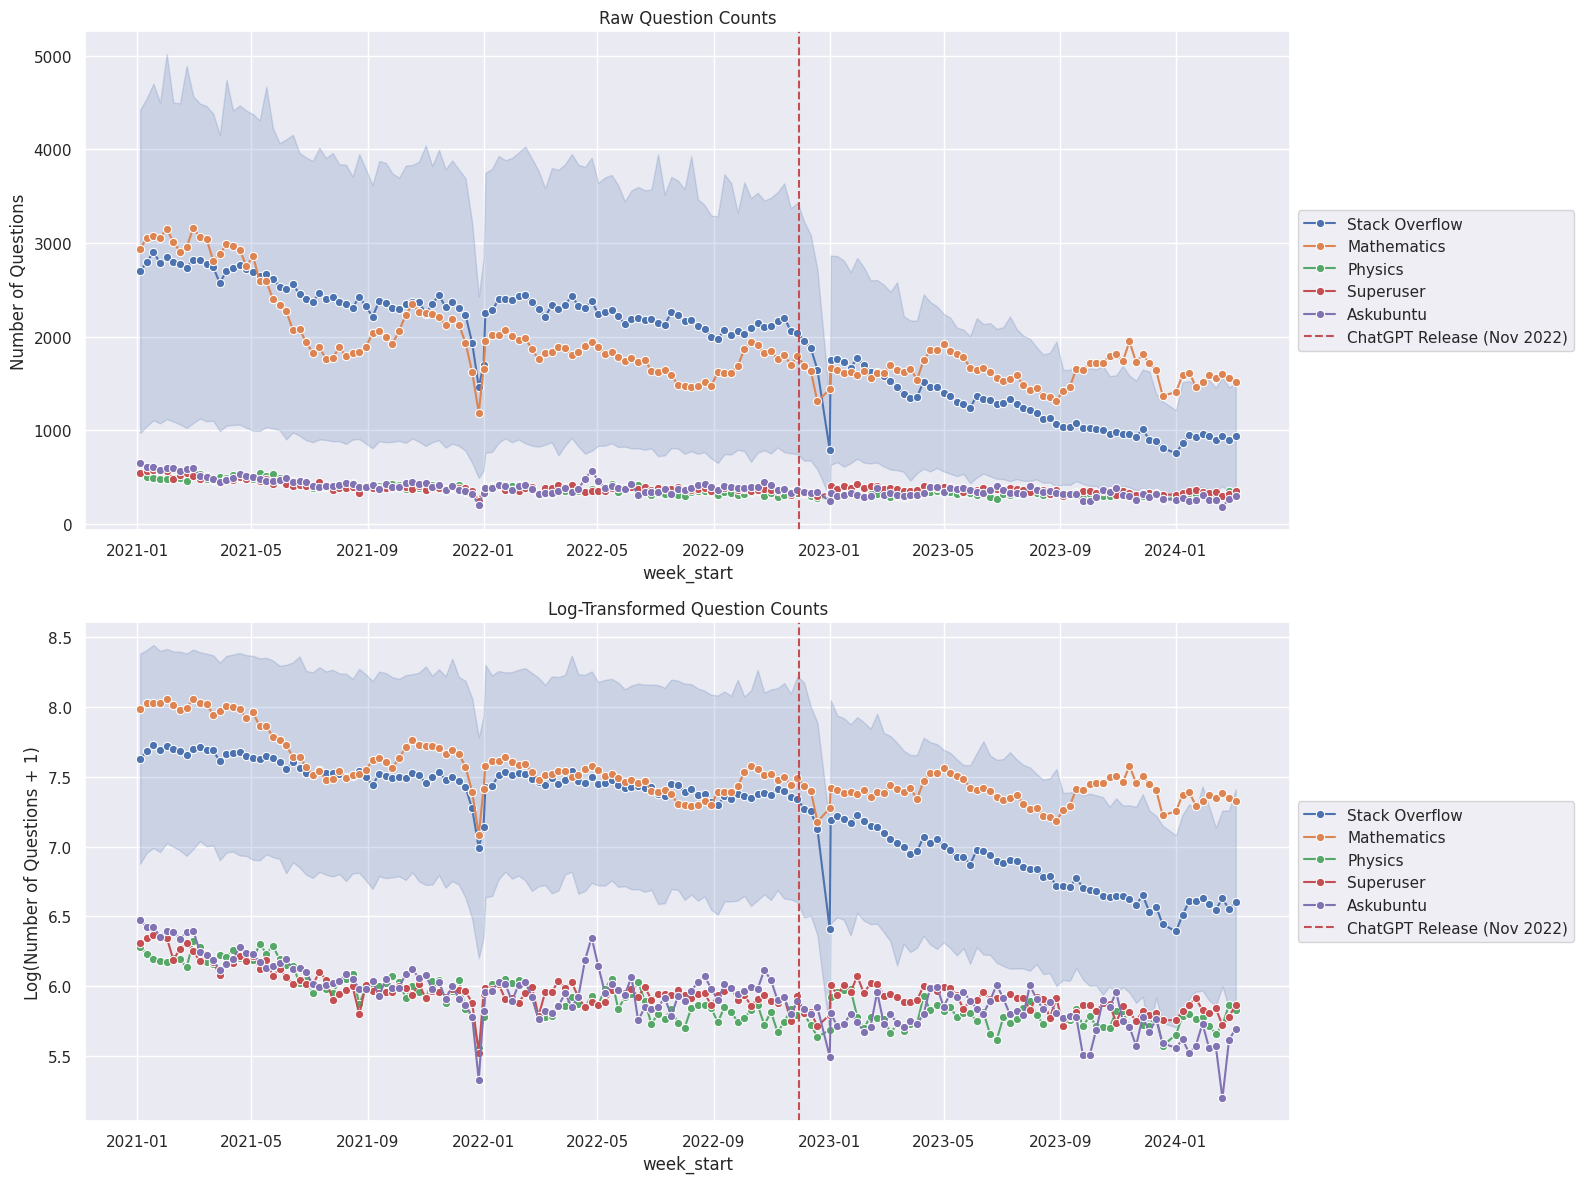

Parallel Trends Tests for Different Transformations:

Raw Counts:
time_trend:forum[T.Stack Overflow]: p = 0.9583 - Non-significant (parallel)
time_trend:forum[T.Mathematics]: p = 0.0415 - Significant (non-parallel)
time_trend:forum[T.Superuser]: p = 0.9326 - Non-significant (parallel)
time_trend:forum[T.Askubuntu]: p = 0.9705 - Non-significant (parallel)

Log Counts:
time_trend:forum[T.Stack Overflow]: p = 0.0323 - Significant (non-parallel)
time_trend:forum[T.Mathematics]: p = 0.6793 - Non-significant (parallel)
time_trend:forum[T.Superuser]: p = 0.5933 - Non-significant (parallel)
time_trend:forum[T.Askubuntu]: p = 0.7182 - Non-significant (parallel)

Indexed Counts:
time_trend:forum[T.Stack Overflow]: p = 0.6994 - Non-significant (parallel)
time_trend:forum[T.Mathematics]: p = 0.8974 - Non-significant (parallel)
time_trend:forum[T.Superuser]: p = 0.8774 - Non-significant (parallel)
time_trend:forum[T.Askubuntu]: p = 0.8762 - Non-significant (parallel)


In [18]:
# Example usage (would be applied to actual data in real implementation)
all_forums_weekly_transformed = transform_for_parallel(all_forums_weekly)
visualize_transformations(all_forums_weekly_transformed)
parallel_tests = test_parallel_trends_transformed(all_forums_weekly_transformed)

In [15]:
# 11. Pivot function for synthetic control
def prepare_data_for_synthetic_control(transformed_data):
    """
    Convert unpivoted data to pivoted format required for synthetic control.

    Parameters:
    -----------
    transformed_data : polars.DataFrame
        DataFrame with forums as values in a 'forum' column

    Returns:
    --------
    pandas.DataFrame
        Pivoted DataFrame with forums as columns
    """
    # Create a pivot table with all relevant metrics
    metrics = ["question_count"]
    if "log_question_count" in transformed_data.columns:
        metrics.append("log_question_count")
    if "indexed_count" in transformed_data.columns:
        metrics.append("indexed_count")

    # Create pivot tables for each metric and join them
    pivot_dfs = []

    for metric in metrics:
        pivot_df = transformed_data.pivot(
            index=["yearweek", "year", "week", "week_start"],
            columns="forum",
            values=metric,
        ).sort("week_start")

        # Rename columns to indicate the metric if we have multiple
        if len(metrics) > 1:
            pivot_df = pivot_df.rename(
                {
                    col: f"{col}_{metric}"
                    for col in pivot_df.columns
                    if col not in ["yearweek", "year", "week", "week_start"]
                }
            )

        pivot_dfs.append(pivot_df)

    # Join all pivot tables
    result = pivot_dfs[0]
    for df in pivot_dfs[1:]:
        result = result.join(
            df, on=["yearweek", "year", "week", "week_start"], how="left"
        )

    # Add treatment indicator
    treatment_date = datetime(2022, 11, 30)
    result = result.with_columns(
        pl.col("week_start").gt(treatment_date).alias("post_treatment")
    )

    return result.to_pandas()

In [16]:
# Then prepare for synthetic control and run it:
pivoted_data = prepare_data_for_synthetic_control(all_forums_weekly_transformed)
outcome_var = "Stack Overflow"
control_vars = ["Mathematics", "Physics", "Superuser", "Askubuntu"]
# If using transformed metrics:
log_outcome_var = "Stack Overflow_log_question_count"
log_control_vars = [f"{forum}_log_question_count" for forum in control_vars]
pre_treatment_mask = pivoted_data["week_start"] <= treatment_date
post_treatment_mask = pivoted_data["week_start"] > treatment_date

In [17]:
# If using transformed metrics:
ind_outcome_var = "Stack Overflow_indexed_count"
ind_control_vars = [f"{forum}_indexed_count" for forum in control_vars]

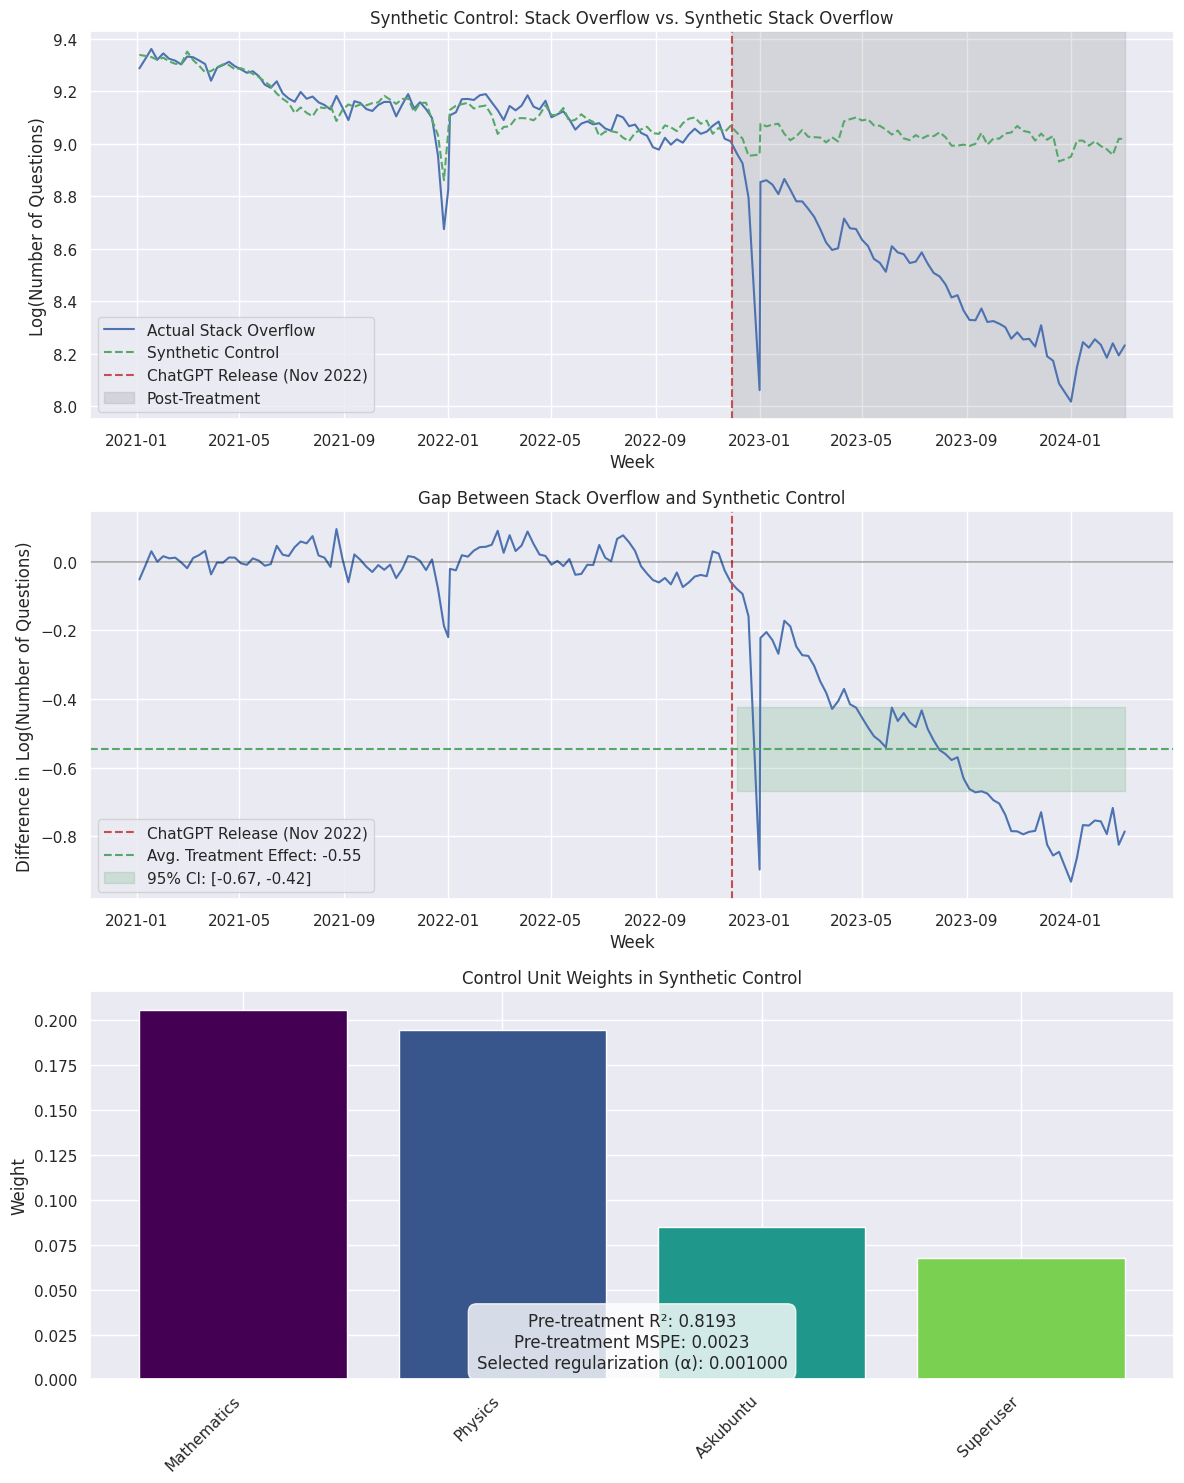

In [18]:
# Then run synthetic control with transformed data:
log_results = enhanced_synthetic_control(
    "Stack Overflow_log_question_count",
    log_control_vars,
    pivoted_data,
    treatment_date,
    pre_treatment_mask,
    post_treatment_mask,
    outcome_transform=None,  # Already transformed
)

vis = visualize_synthetic_control(
    pivoted_data, log_results, "Stack Overflow", transformation="log"
)

In [19]:
# 12. Calculate t-statistic for the treatment effect
t_stat = log_results["att"] / log_results["se"]
p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

T-Statistic: -8.7548, P-Value: 0.0000


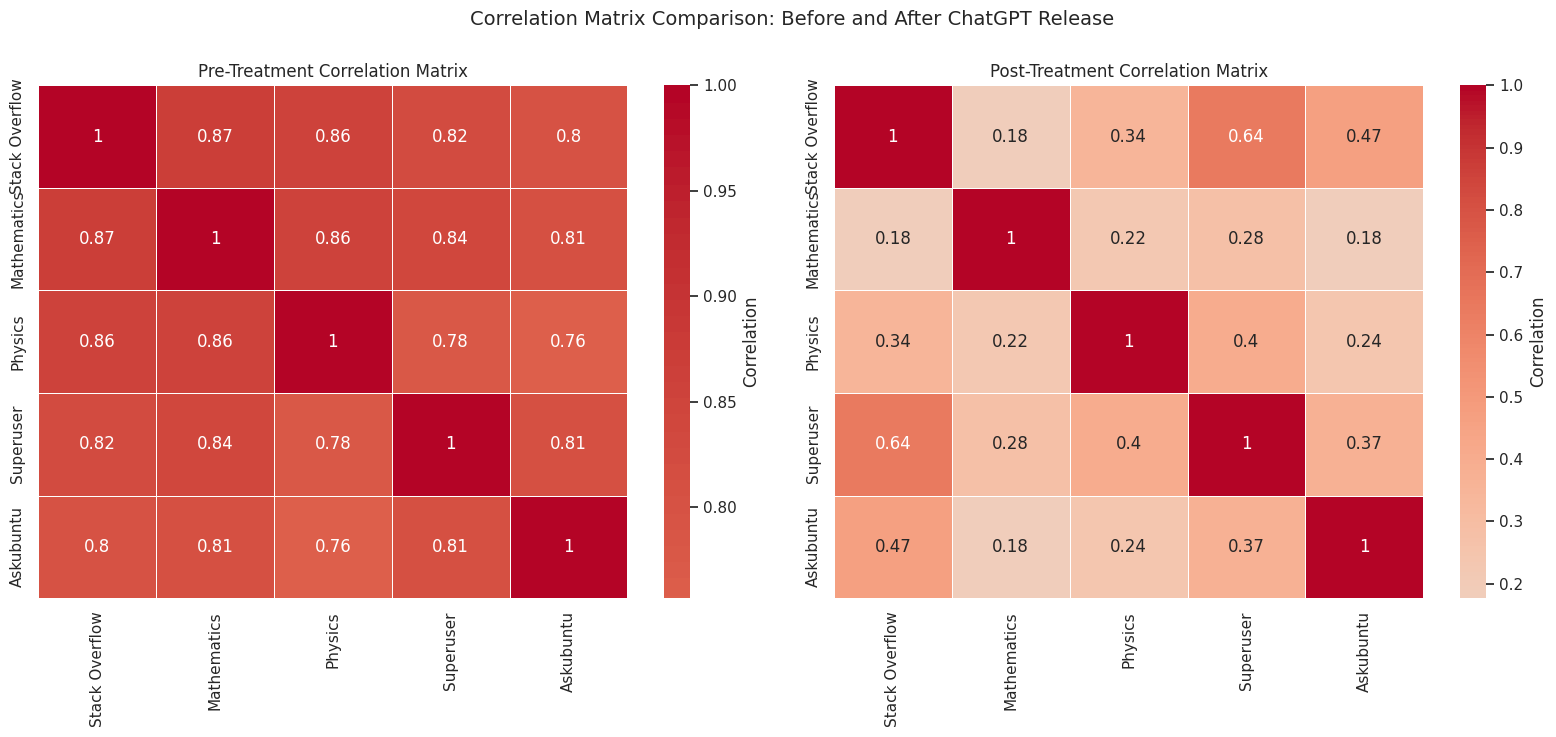

In [20]:
# 13. Create subfigures for pre-treatment and post-treatment correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

all_forums_weekly_transformed1 = pl.from_pandas(pivoted_data)

# Specify which transformation to use
cat = (
    "_log_question_count"  # "_indexed_count"  # Use indexed count for better comparison
)
correlation_cols = [x for x in all_forums_weekly_transformed1.columns if cat in x]
labels = [x.replace(cat, "") for x in correlation_cols]

# Pre-treatment correlation matrix
pre_data = all_forums_weekly_transformed1.filter(
    pl.col("week_start") <= treatment_date
).drop_nans()
pre_corr = pre_data.select(correlation_cols).corr()

sns.heatmap(
    pre_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"},
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[0],
)
axes[0].set_title("Pre-Treatment Correlation Matrix")

# Post-treatment correlation matrix
post_data = all_forums_weekly_transformed1.filter(
    pl.col("week_start") > treatment_date
).drop_nans()
post_corr = post_data.select(correlation_cols).corr()

sns.heatmap(
    post_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"},
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[1],
)
axes[1].set_title("Post-Treatment Correlation Matrix")

plt.tight_layout()
plt.suptitle(
    "Correlation Matrix Comparison: Before and After ChatGPT Release",
    y=1.05,
    fontsize=14,
)
plt.savefig("../imgs/pre-post_correlation_matrices.svg")
plt.show()

## Data dumps

Store data for other analysis

In [19]:
# Data for Stata
df_stata = all_forums_weekly_transformed.with_columns(
    pl.when(pl.col("forum").eq("Stack Overflow")).then(1).otherwise(0).alias("treated"),
    pl.when(pl.col("week_start").gt(treatment_date))
    .then(1)
    .otherwise(0)
    .alias("treatment"),
    pl.when(
        pl.col("week_start").gt(treatment_date) & pl.col("forum").eq("Stack Overflow")
    )
    .then(1)
    .otherwise(0)
    .alias("treatment_synthdid"),
    # Weeks indexed
    pl.col("week_start").rank(method="dense").sub(1).alias("week_index"),
)

month_cont = (
    all_forums_weekly_transformed.with_columns(
        # Month controls
        (pl.col("week_start").dt.year() * 100 + pl.col("week_start").dt.month()).alias(
            "year_month"
        )
    )
    .select("year_month")
    .to_dummies(drop_first=True)
)

quarter_cont = (
    all_forums_weekly_transformed.with_columns(
        # Quarter controls
        (pl.col("week_start").dt.year() * 10 + pl.col("week_start").dt.quarter()).alias(
            "year_quarter"
        )
    )
    .select("year_quarter")
    .to_dummies(drop_first=True)
)

df_stata = pl.concat([df_stata, month_cont, quarter_cont], how="horizontal")

df_stata.drop(["avg_score", "avg_views", "avg_comments"]).to_pandas().to_stata(
    "../data/stata/so_script1.dta"
)

In [13]:
# Data for pysynthdid
all_forums_weekly_transformed1 = all_forums_weekly_transformed.with_columns(
    pl.when(
        pl.col("week_start").gt(treatment_date) & pl.col("forum").eq("Stack Overflow")
    )
    .then(1)
    .otherwise(0)
    .alias("treatment")
)

all_forums_weekly_transformed1.write_parquet(
    "../data/all_forums_weekly_transformed.parquet"
)

In [14]:
# Data for SynapeML
synapseml = all_forums_weekly_transformed.with_columns(
    pl.col("week_start").gt(treatment_date).alias("treatment"),
    pl.when(pl.col("forum").eq("Stack Overflow")).then(1).otherwise(0).alias("outcome"),
)
synapseml.write_parquet("../data/synapseml.parquet")